# Activity Classification

## 1. Load Packages and Data

In [1]:
!pip install --upgrade dask dask-ml pandas scikit-learn seaborn



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [3]:
# Load dataset
path = "/home/work/Final/"

df_watch_a = dd.read_csv(path + "features_watch_a.csv")


In [4]:
# Convert to pandas for LOSO (Leave One Sample Out) handling 
df = df_watch_a.compute()

# Extract subject IDs
subject_ids = df['sub_id'].unique()

# Encode labels once on the whole dataset
label_enc = LabelEncoder()
df['activity_encoded'] = label_enc.fit_transform(df['activity'])

# Features to drop
drop_cols = ['sub_id', 'group_id', 'activity', 'activity_encoded']

# Features
X_all = df.drop(columns=drop_cols)
y_all = df['activity_encoded']

# Create list to store metrics
train_accuracies = []
test_accuracies = []
conf_matrix_sum = np.zeros((len(label_enc.classes_), len(label_enc.classes_)), dtype=int)
all_reports = []

# Feature importance accumulation
feature_importances_sum = np.zeros(X_all.shape[1])

In [5]:
# Splitting data for LOSO and training/applying model for each test-subject
for test_sub in subject_ids:
    # Split data
    train_mask = df['sub_id'] != test_sub
    test_mask = df['sub_id'] == test_sub
    
    X_train = X_all.loc[train_mask]
    y_train = y_all.loc[train_mask]
    X_test = X_all.loc[test_mask]
    y_test = y_all.loc[test_mask]
    
    # Scale features (fit on train only)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train RF
    rf = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_leaf=3, min_samples_split=3, random_state=42)
    rf.fit(X_train_scaled, y_train)
    
    # Predictions
    y_train_pred = rf.predict(X_train_scaled)
    y_test_pred = rf.predict(X_test_scaled)
    
    # Accuracies
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred, labels=range(len(label_enc.classes_)))
    conf_matrix_sum += cm
    
    # Classification report (dict)
    report = classification_report(y_test, y_test_pred, output_dict=True, zero_division=0)
    all_reports.append(report)
    
    # Feature importance sum
    feature_importances_sum += rf.feature_importances_
    

Average Train Accuracy: 0.625
Average Test Accuracy:  0.625

Average Confusion Matrix (Normalized by True Class):
[[5.75381679e-01 1.10687023e-01 4.77099237e-02 0.00000000e+00
  9.54198473e-04 0.00000000e+00 1.90839695e-02 9.54198473e-04
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.44083969e-01 3.62595420e-02 0.00000000e+00 0.00000000e+00
  3.81679389e-03 6.10687023e-02]
 [9.75609756e-04 9.52195122e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 2.92682927e-03 9.75609756e-04
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  9.75609756e-04 1.75609756e-02 2.04878049e-02 0.00000000e+00
  2.92682927e-03 9.75609756e-04]
 [1.89922481e-01 1.45348837e-02 2.49031008e-01 3.87596899e-03
  6.78294574e-03 0.00000000e+00 1.55038760e-02 4.65116279e-02
  3.87596899e-03 1.93798450e-03 9.68992248e-04 0.00000000e+00
  2.88759690e-01 2.42248062e-02 6.78294574e-03 0.00000000e+00
  0.00000000e+00 1.47286822e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e

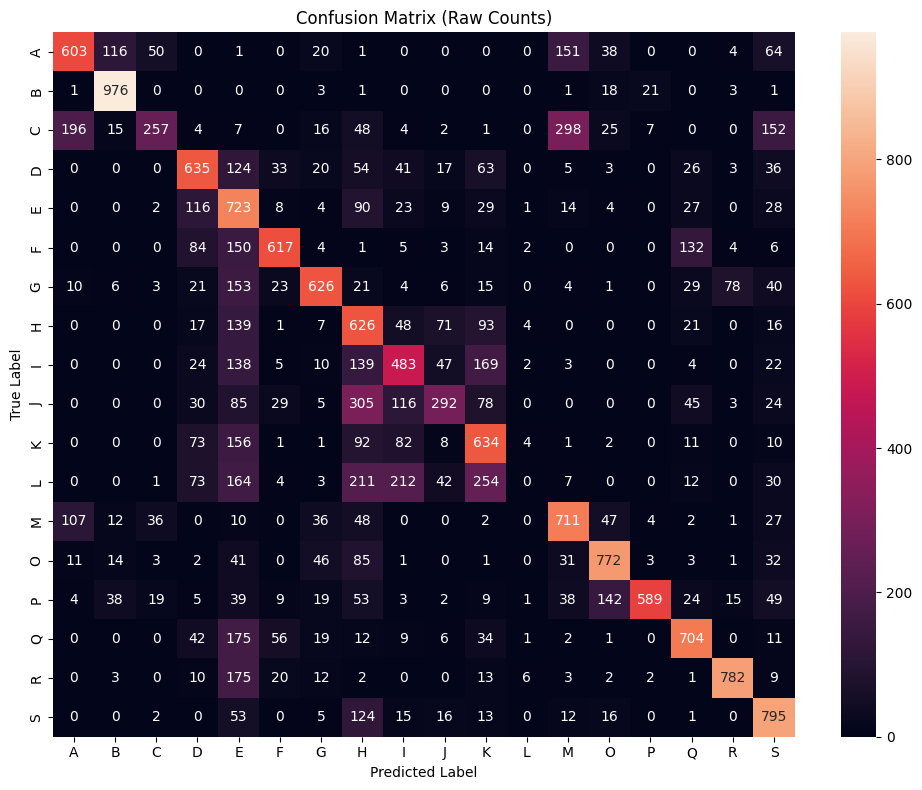

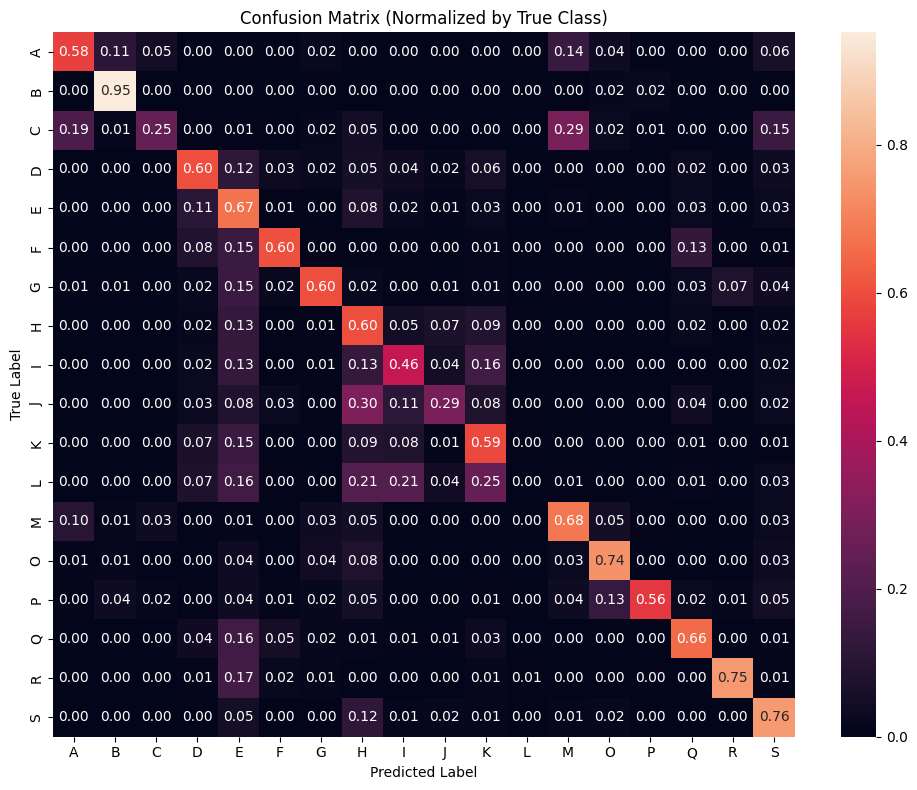


Average Classification Report (per-class precision, recall, f1-score):
A: Precision: 0.680, Recall: 0.642, F1-score: 0.631
B: Precision: 0.913, Recall: 0.947, F1-score: 0.915
C: Precision: 0.632, Recall: 0.263, F1-score: 0.343
D: Precision: 0.603, Recall: 0.660, F1-score: 0.606
E: Precision: 0.680, Recall: 0.709, F1-score: 0.660
F: Precision: 0.647, Recall: 0.672, F1-score: 0.633
G: Precision: 0.790, Recall: 0.653, F1-score: 0.687
H: Precision: 0.464, Recall: 0.667, F1-score: 0.509
I: Precision: 0.412, Recall: 0.523, F1-score: 0.434
J: Precision: 0.491, Recall: 0.324, F1-score: 0.356
K: Precision: 0.515, Recall: 0.636, F1-score: 0.538
L: Precision: 0.000, Recall: 0.000, F1-score: 0.000
M: Precision: 0.619, Recall: 0.708, F1-score: 0.634
O: Precision: 0.699, Recall: 0.816, F1-score: 0.740
P: Precision: 0.826, Recall: 0.639, F1-score: 0.664
Q: Precision: 0.664, Recall: 0.758, F1-score: 0.681
R: Precision: 0.824, Recall: 0.852, F1-score: 0.821
S: Precision: 0.647, Recall: 0.848, F1-score

In [6]:
# Average metrics
avg_train_acc = np.mean(train_accuracies)
avg_test_acc = np.mean(test_accuracies)
avg_feature_importances = feature_importances_sum / len(subject_ids)

# Average confusion matrix normalized by row (per-class recall)
conf_matrix_avg = conf_matrix_sum / conf_matrix_sum.sum(axis=1, keepdims=True)

# Average classification report (macro average for key metrics)
def average_classification_reports(reports):
    keys = list(reports[0].keys())
    avg_report = {}

    # Collect all possible class labels across all reports as strings
    all_class_labels = set()
    for r in reports:
        all_class_labels.update([k for k in r.keys() if k not in ['accuracy', 'macro avg', 'weighted avg']])
    all_class_labels = sorted(all_class_labels, key=lambda x: (not x.isdigit(), x))  # digits first, then others

    for k in keys:
        if k == 'accuracy':
            avg_report[k] = np.mean([r.get(k, 0) for r in reports])
        elif isinstance(reports[0][k], dict):
            avg_report[k] = {}
            # If it's a class label, make sure to cover all classes even if missing in some reports
            if k in all_class_labels or k in ['macro avg', 'weighted avg']:
                metrics = set()
                for r in reports:
                    if k in r:
                        metrics.update(r[k].keys())
                for metric in metrics:
                    # Average metric over reports that have the class k and the metric
                    vals = [r[k][metric] for r in reports if k in r and metric in r[k]]
                    avg_report[k][metric] = np.mean(vals) if vals else 0
        else:
            avg_report[k] = np.mean([r.get(k, 0) for r in reports])

    # Also fill missing class keys with zero scores if they weren't added
    for class_label in all_class_labels:
        if class_label not in avg_report:
            avg_report[class_label] = {'precision': 0, 'recall': 0, 'f1-score': 0, 'support': 0}

    return avg_report


avg_report = average_classification_reports(all_reports)

# Print results
print(f"Average Train Accuracy: {avg_train_acc:.3f}")
print(f"Average Test Accuracy:  {avg_test_acc:.3f}")
print("\nAverage Confusion Matrix (Normalized by True Class):")
print(conf_matrix_avg)

print("\nAverage Confusion Matrix (Raw counts):")
print(conf_matrix_sum)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_sum, annot=True, fmt='d',
            xticklabels=label_enc.classes_, yticklabels=label_enc.classes_)
plt.title("Confusion Matrix (Raw Counts)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_avg, annot=True, fmt='.2f',
            xticklabels=label_enc.classes_, yticklabels=label_enc.classes_)
plt.title("Confusion Matrix (Normalized by True Class)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


print("\nAverage Classification Report (per-class precision, recall, f1-score):")
for label_idx, label_name in enumerate(label_enc.classes_):
    pr = avg_report[str(label_idx)]
    print(f"{label_name}: Precision: {pr['precision']:.3f}, Recall: {pr['recall']:.3f}, F1-score: {pr['f1-score']:.3f}")

print(f"\nOverall Accuracy: {avg_report['accuracy']:.3f}")


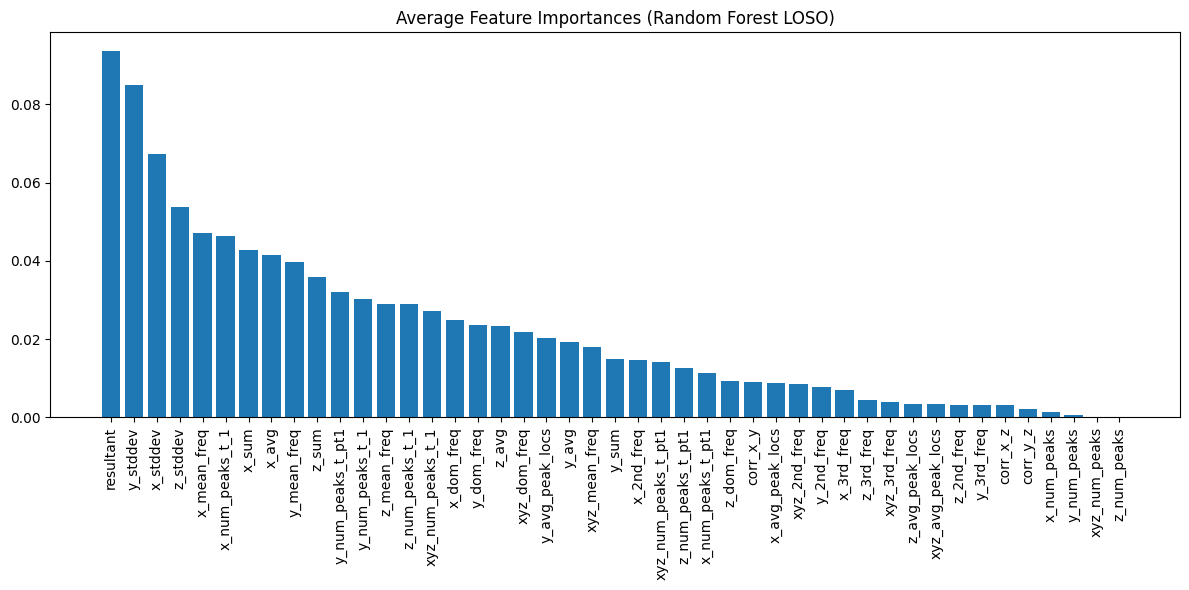

In [7]:
# Plot feature importances
feature_names = X_all.columns
indices = np.argsort(avg_feature_importances)[::-1]
top_n = 45

plt.figure(figsize=(12, 6))
plt.title("Average Feature Importances (Random Forest LOSO)")
plt.bar(range(top_n), avg_feature_importances[indices[:top_n]], align='center')
plt.xticks(range(top_n), feature_names[indices[:top_n]], rotation=90)
plt.tight_layout()
plt.show()


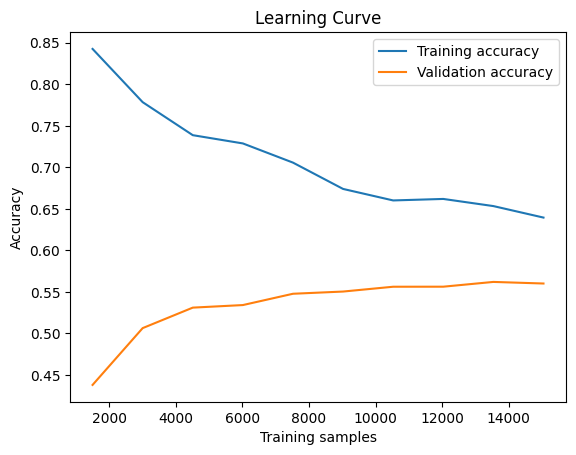

In [8]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, val_scores = learning_curve(
    rf, X_all, y_all, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label='Training accuracy')
plt.plot(train_sizes, val_mean, label='Validation accuracy')
plt.xlabel('Training samples')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()


In [9]:
from sklearn.linear_model import LogisticRegression

# Storage for logistic regression metrics
logreg_train_accuracies = []
logreg_test_accuracies = []
logreg_conf_matrix_sum = np.zeros((len(label_enc.classes_), len(label_enc.classes_)), dtype=int)
logreg_all_reports = []

for test_sub in subject_ids:
    # Same data splits and scaling as before...
    
    # Logistic Regression
    logreg = LogisticRegression(max_iter=1000, random_state=42)
    logreg.fit(X_train_scaled, y_train)
    
    y_train_pred_logreg = logreg.predict(X_train_scaled)
    y_test_pred_logreg = logreg.predict(X_test_scaled)
    
    train_acc_logreg = accuracy_score(y_train, y_train_pred_logreg)
    test_acc_logreg = accuracy_score(y_test, y_test_pred_logreg)
    
    logreg_train_accuracies.append(train_acc_logreg)
    logreg_test_accuracies.append(test_acc_logreg)
    
    cm_logreg = confusion_matrix(y_test, y_test_pred_logreg, labels=range(len(label_enc.classes_)))
    logreg_conf_matrix_sum += cm_logreg
    
    report_logreg = classification_report(y_test, y_test_pred_logreg, output_dict=True, zero_division=0)
    logreg_all_reports.append(report_logreg)

# Average metrics for logistic regression
avg_train_acc_logreg = np.mean(logreg_train_accuracies)
avg_test_acc_logreg = np.mean(logreg_test_accuracies)

# You can reuse your `average_classification_reports` function here
avg_report_logreg = average_classification_reports(logreg_all_reports)

# Then print and plot results similarly
print(f"Logistic Regression Average Train Accuracy: {avg_train_acc_logreg:.3f}")
print(f"Logistic Regression Average Test Accuracy: {avg_test_acc_logreg:.3f}")
# ...and so on


Logistic Regression Average Train Accuracy: 0.664
Logistic Regression Average Test Accuracy: 0.771
